# **Homework 4:** The Hunt for the USS Scorpion (Part III)
## HMMs, forwards-backwards, variable elimination
STATS348, UChicago, Spring 2023

----------------
**Your name here:**

----------------

<a href="https://colab.research.google.com/github/Goldreich/stat_348/blob/main/assignments/hw4/hw4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---

## Instructions

The purpose of this homework is to apply the ideas in lectures 7-9:
* probabilistic graphical models
* hidden Markov models (HMMs)
* variable elimination 
* belief propagation (BP) AKA the sum-product algorithm
* forwards-backwards algorithm (i.e., BP for HMMs).

Assignment is due **Monday May 1, 11:59pm** on GradeScope.

## Setting

You are back to searching for the missing submarine, the USS _Scorpion_.

As a reminder, it is May 1968 and the USS _Scorpion_ has just disappeared somewhere in the Atlantic Ocean, likely off the coast of Spain. You are the lone statistician on board the USS _Mizar_, which has been dispatched to find the missing submarine. Your job is to guide the search as best you can, given the data at your disposal.

## The search grid
The search grid will play a central role in this episode. The Navy has divided the search into a $(33 \times 26)$ grid of square-mile cells. The center of the grid is the rough location of loud acoustic event, likely an explosion, that was recorded around the time when the USS _Scorpion_ disappeared. The search grid, overlayed on a topographic map of the ocean floor is displayed below; the red dot is the rough location of the acoustic event.

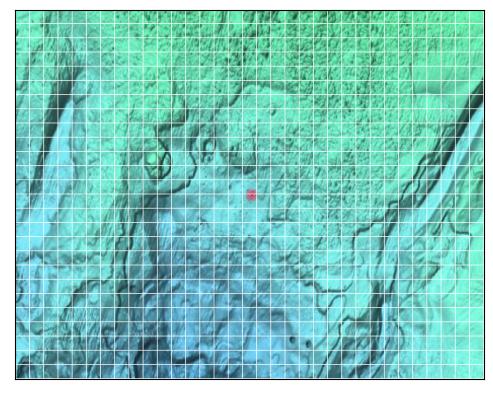

In [ ]:
from hw_utils import plot_scorpion_search_grid, get_scorpion_search_grid
plot_scorpion_search_grid(show=True)

### Cell coordinates versus cell indices

There are $K = 33 \times 26 = 858$ total cells in the grid. We can number each cell $k \in \{1,\dots,K\}$. Each cell therefore has an index $k$ as well as coordinates $(x,y)$ on the grid.

The `ravel_multi_index` and `unravel_index` functions let us map between these two.
See below for an explainer on these `numpy` functions.

In [2]:
import numpy as np
import numpy.random as rn

xy = (16, 12)
k = np.ravel_multi_index(xy, dims=(33, 26))
print(f'Cell {k} is in location {xy}')

k = 4
xy = np.unravel_index(k, shape=(33, 26))
print(f'Cell {k} is in location {xy}')

# this indexing system is based on the "ravel" operation

# consider the following 4d numpy array of random numbers
shape = (4,5,6,7)
arr = rn.random(shape)

# we can ravel this array, so that it is 1d
arr_raveled = arr.ravel()
assert arr_raveled.shape == (np.prod(shape),)

# the functions above let us map between the raveled index and the original multi-index
multi_index = (1, 2, 0, 5)
ravel_index = np.ravel_multi_index(multi_index, shape)
assert arr[multi_index] == arr_raveled[ravel_index]

ravel_index = 50
multi_index = np.unravel_index(ravel_index, shape)
assert arr[multi_index] == arr_raveled[ravel_index]

Cell 428 is in location (16, 12)
Cell 4 is in location (0, 4)


## Sonar blips
An unnamed intelligency agency has reported that its underwater listening devices detected anomalous sonar blips directly after the explosion in the same general area. The sonar blips may correspond to the USS _Scorpion_'s final movements after some catastrophic event. 

Based on the sonar data, and on the captain's expert opinion, we believe the _Scorpion_ was active for some period between 0-24 hours after the explosion, after which it likely sank. Define the following quantities:


\begin{align}
\nonumber t &=0 & &\textrm{ time of the explosion} \\
\nonumber T &= 24 & &\textrm{ max num. of hours before the sub sank} \\
\nonumber \tau &\in \{1,\dots, T\} & &\textrm{ (unknown) hour of sinking} \\
\nonumber Z_t &\in \{1, \dots, K\} & &\textrm{ what cell the sub was in at hour $t$} \\
\nonumber Z_T &\in \{1, \dots, K\} & &\textrm{ the sub's final resting place (where it is now)} \\
\end{align}


## Possible scenarios
We convened a panel of submarine experts to imagine what might have happened in the hours between the explosion and when the sub ultimately sank. 

They imagined $6$ possible scenarios that could have plausibly occurred.

| Scenario $s$    | Description | Expected hours alive $\mathbb{E}[\tau \mid s]$ | Prior probability of scenario $P(s)$ |
| ----------- | ----------- | ----------- | ----------- | 
| flounder    | The _Scorpion_ suffered a catestrophic malfunction; it moved aimlessly before sinking quickly. | 4 | 0.35 | 
| drift       | The _Scorpion_ suffered a catestrophic malfunction; it drifted East with the tide before sinking quickly. | 6 | 0.2 |
| reverse course  | The _Scorpion_ suffered a major malfunction; it reversed course back to base (Northeast), and sailed for a while before sinking. | 12 | 0.15 |
| seek shallow  | The _Scorpion_ suffered a major malfunction; it sought shallower waters, and sailed for a while before sinking. | 6 | 0.1 |
| evade   | The _Scorpion_ was seriously damaged by an enemy attack; it took evasive maneuvers, moving unpredictably and changing course often, but sank soon after.    | 4 | 0.1 |
| seek ridge   | The _Scorpion_ was lightly damaged by an enemy attack; it manuevered quickly into an underwater ridge for cover, but collided with the narrow ridge and sank. | 12 | 0.1 |

The experts have assigned each scenario a prior probabability $P(S=s)$ for $s \in \mathcal{S} \equiv \{\textrm{flounder}, \textrm{evade},\dots\}$.

They have also constructed a prior over the hour-of-sinking $\tau$ under each scenario. Since they strongly believe the sub could not have survived longer than 24 hours, the prior is binomial
\begin{align}
P(\tau \mid s) = \textrm{Binom}(\tau;\,T,\, \rho_s),\,\,\, \tau \in \{0,2,\dots,T\}
\end{align}
where $\rho_s \in (0,1)$ and $\mathbb{E}[\tau \mid s] = T\rho_s$ 

We have implemented the expert's prior in the code below. The function `get_tau_prior` takes $T$ and $(\rho_s)_{s \in \mathcal{S}}$ and uses [closure](https://www.learnpython.org/en/Closures) to define and return a conditional function `tau_prior` which will return $P(\tau \mid s)$ for an input scenario $s$.

In [3]:
import pandas as pd
import scipy.stats as st

df_scenarios = pd.DataFrame()
df_scenarios['scenario'] = ['flounder', 'drift', 'reverse_course', 'seek_shallow', 'evade', 'seek_ridge']
df_scenarios['rho_s'] = [4./24, 6./24, 12./24, 6./24, 4./24, 12./24]
df_scenarios['p(s)'] = [0.35, 0.2, 0.15, 0.1, 0.1, 0.1]

def get_tau_prior(max_timesteps, rho_dict):
    def tau_prior(scenario):
        rho = rho_dict[scenario]
        return st.binom(max_timesteps, rho).pmf(np.arange(max_timesteps+1))
    return tau_prior

rho_dict = df_scenarios.set_index('scenario').to_dict()['rho_s']
tau_prior = get_tau_prior(max_timesteps=24, rho_dict=rho_dict)

You can interact with `tau_prior` in the following way.

<ipython-input-4-92cf3b165693>:7: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  _ = plt.stem(P_tau_given_flounder, use_line_collection=True)


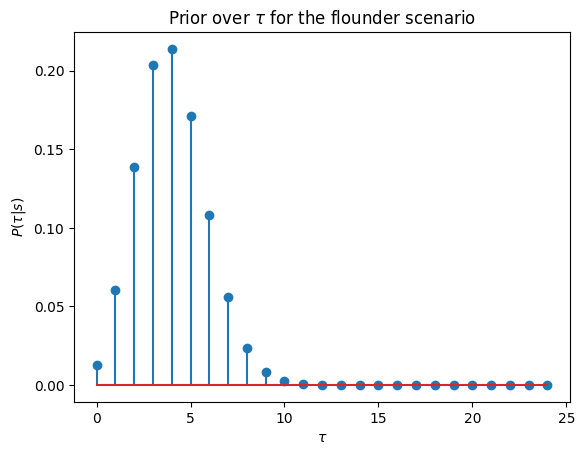

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

P_tau_given_flounder = tau_prior('flounder')
assert P_tau_given_flounder.shape == (25,)

_ = plt.stem(P_tau_given_flounder, use_line_collection=True)
_ = plt.xlabel('$\\tau$')
_ = plt.ylabel('$P(\\tau | s)$')
_ = plt.title('Prior over $\\tau$ for the flounder scenario')

## A scenario-based Markov model

For each of the 6 scenarios, the experts have also put together a simple model of the _Scorpion_'s likely movements while it was still alive. Each model is a _Markov model_, which posits the following transition behavior based on the scenario $s$ and time-of-death $\tau$:

For $t=1,\dots, T$:
\begin{align}
P_{s, \tau}(Z_t = k \mid Z_{t-1} = j) &= 
\begin{cases}
\Lambda_s(j, k) & \textrm{if }t \leq \tau \\
0 & \textrm{if }t > \tau \textrm{ and } j \neq k \\
1 & \textrm{if }t > \tau \textrm{ and } j = k \\
\end{cases}
\end{align}

For $t=0$:
\begin{align}
P(Z_0 = k) &= \pi_0(k)
\end{align}

$\pi_0 \in (0,1)^K$ is the _initial distribution_ over cells where the _Scorpion_ may have been at $t=0$.

$\Lambda_s \in (0,1)^{K \times K}$ is a row-stochastic _transition matrix_, where the rows sum to 1:

\begin{align}
\sum_{k=1}^K \Lambda_s(j, k) = 1,\,\,\forall j
\end{align}

There is a different transition matrix $\Lambda_s$ for each scenario $s$; each one describes a different pattern of movement. You can load them using `pickle` below.

In [6]:
import pickle
with open('transition_matrices.pkl', 'rb') as f:
    transition_matrices = pickle.load(f)

print(transition_matrices.keys())
assert all(transition_matrices[s].shape == (858, 858) for s in transition_matrices.keys())

dict_keys(['flounder', 'evade', 'drift', 'reverse_course', 'seek_shallow', 'seek_ridge'])


We provide functions to sample paths for a given transition matrix and to plot those paths over the search grid. 

You can play with them to see what kinds of paths are typical under each scenario.

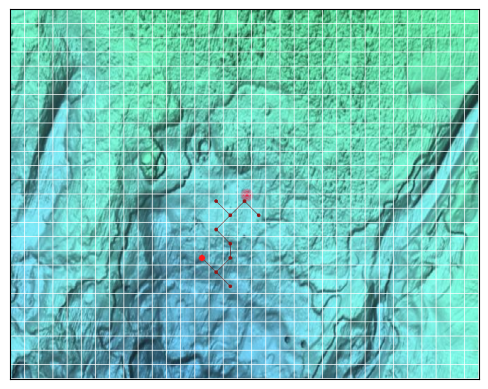

In [11]:
from hw_utils import plot_scorpion_path

def sample_markov(transition_matrix,  n_timesteps=10, start_cell=428):
    """ Sample a path from a Markov chain with the given transition matrix.

    Parameters
    ----------
    transition_matrix : np.ndarray
        A square matrix of shape (n_cells, n_cells) where n_cells is the number of cells in the grid.
        The (i,j) entry of this matrix is the probability of transitioning from cell i to cell j.
    n_timesteps : int
        The number of timesteps to sample.
    start_cell : int
        The index of the cell to start the path from.
        Default value is 428, corresponding to (16,12) on the grid, where the explosion occurred.
    """
    n_cells = transition_matrix.shape[0]

    path = [start_cell]
    for _ in range(n_timesteps):
        next_cell = rn.choice(n_cells, p=transition_matrix[path[-1]])
        path.append(next_cell)
    return path

path = sample_markov(transition_matrices['evade'], n_timesteps=12)
path = [np.unravel_index(k, shape=(33, 26)) for k in path]  # convert to (x,y) coordinates
plot_scorpion_path(path, show=True)

You can load the initial distribution $\pi_0 \in (0,1)^K$ below using `numpy.load`.

We have provided a function to plot a probability distribution over the search grid.

This function will darken cells inversely proportional to their probability under the distribution.

For instance, if $\pi_0(k) \approx 0$, then cell $k$ will be black.


The function requires you to first `reshape` the distribution into a 2d array where the (row,col) indices match the $(x,y)$-coordinates on the grid.

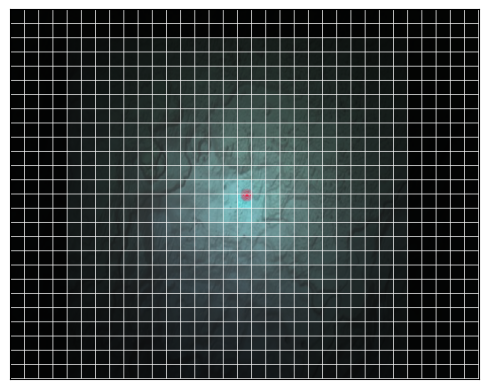

In [12]:
from hw_utils import plot_dist_on_scorpion_search_grid

initial_dist_K = np.load('initial_dist.npy') # \pi_0
assert initial_dist_K.shape == (858,)

plot_dist_on_scorpion_search_grid(dist=initial_dist_K.reshape((33, 26)), show=True)

## Sonar likelihood

As mentioned before, underwater listening devices picked up an anomalous pattern of sonar blips in the hours after the explosion.

There were $D$ listening devices in the area. Let $u_d \in \{1,\dots, K\}$ be the cell location of the $d^{\textrm{th}}$ device.

Assume the following conditional likelihood for $t \in \{1,\dots, T\}$ and sonar station $d \in \{1, \dots, D\}$. This likelihood conditions on the location $Z_t=z_t$ of the sub at time $t$, and the hour-of-sinking $\tau$.
$
\begin{align}
x_{t,d} &\sim \begin{cases}
\textrm{Pois}(\mu_{d,0} + \mu_d(z_t)) & &\textrm{if } t \leq \tau \\
\textrm{Pois}(\mu_{d,0}) & &\textrm{if } t > \tau
\end{cases}
\end{align}
$
where $\mu_d(z_t) = \gamma_d \, \exp\left(-\tfrac{1}{2}\,\textrm{dist}(z_t, u_d)\right)$. Here, $\textrm{dist}(z_t, u_d)$ is the distance between the sub at $t$ and listening cell $d$,while $\gamma_d$ is a parameter that is fixed and known. 

$\mu_{0,d}$ is the background rate of sonar blips for device $d$; it is also fixed and known.

It is also useful to define the *likelihood vector* at time $t$, conditional on $\tau$; this is:
$$
\begin{align}
\boldsymbol{\ell}^{\tau}_{t} &= \begin{bmatrix}
           P_\tau({\boldsymbol{x}}_{t} \mid Z_t=1) \\
           P_\tau({\boldsymbol{x}}_{t} \mid Z_t=2) \\
           \vdots \\
           P_\tau({\boldsymbol{x}}_{t} \mid Z_t=K)
         \end{bmatrix}
  \end{align}
$$
An element of it is $\ell^{\tau}_{t}(k) = P_\tau(\boldsymbol{x}_{t} \mid Z_t=k) \equiv \prod_{d=1}^D P(x_{t,d} \mid Z_t=k,\, \tau)$.

For your convenience, we have implemented the following function `get_sonar_likelihood`. It takes in the grid shape, the listening device locations $(u_d)_{d=1}^D$, and the parameters $(\mu_{0,d},\gamma_d)_{d=1}^D$, and then uses [closure](https://www.learnpython.org/en/Closures) to define and return a conditional function `sonar_likelihood` that will return a 2-d table $(\boldsymbol{\ell}^{\tau}_{t})_{t=1}^T$ for a given $\tau$.

(You do not need to study the details of this function as long as you understand the input and output of `sonar_likelihood`.)

In [13]:
import scipy.stats as st

def distance_between_cells(k1, k2, grid_shape=(33, 26)):
    x1, y1 = np.unravel_index(k1, grid_shape)
    x2, y2 = np.unravel_index(k2, grid_shape)
    return np.sqrt((x1 - x2)**2 + (y1 - y2)**2)

def get_sonar_likelihood(grid_shape, u_D, mu0_D, gam_D):
    n_stations = len(u_D)
    assert n_stations == mu0_D.size == gam_D.size

    # possible values of Z_t (0-indexed, so 0...K-1)
    n_cells = np.prod(grid_shape)

    # compute distance between each listening station and every other cell in the grid
    distances_DK = np.zeros((n_stations, n_cells))
    for d, k in np.ndindex((n_stations, n_cells)):
        distances_DK[d, k] = distance_between_cells(u_D[d], k)
    
    # define a likelihood function that will output the likelihood table, for a given tau
    def sonar_likelihood(sonar_data, tau):
        assert sonar_data.ndim == 2
        n_timesteps, n_stations = sonar_data.shape
        assert 0 <= tau <= n_timesteps   

        Mu_TKD = np.ones((n_timesteps, n_cells, n_stations)) * mu0_D
        if tau > 0:
            Mu_TKD[:tau] += gam_D * np.exp(-0.5 * distances_DK.T)

        L_TK = st.poisson.pmf(sonar_data[:, None, :], Mu_TKD).prod(axis=-1)

        return L_TK

    return sonar_likelihood

We can now load in the parameters of the listening devices $(u_d, \mu_{0,d}, \gamma_d)_{d=1}^D$ and use them to define a likelihood.

In [14]:
arrays = np.load('listening_stations.npz')
# the cell indices of each listening device
u_D = arrays['u_D']
# the background rate of each listening device \mu_{0,d}
mu0_D = arrays['mu0_D']
# the parameter \gamma_{d} for each listening device
gam_D = arrays['gam_D']

# define a likelihood function for these parameters
sonar_likelihood = get_sonar_likelihood((33, 26), u_D, mu0_D, gam_D)


And finally, we can load in the sonar data $\boldsymbol{x}_{1:T}$, and evaluate its likelihood for different values of $\tau$:

In [15]:
# load in the sonar data
sonar_data = np.load('sonar_data.npy')
assert sonar_data.shape == (24, len(u_D))

# compute the likelihood table for tau=0
L_TK = sonar_likelihood(sonar_data, tau=0)
assert L_TK.shape == (24, 858)

# compute the likelihood table for tau=24
L_TK = sonar_likelihood(sonar_data, tau=24)
assert L_TK.shape == (24, 858)

## Question 1 [Visualize] (10pts)

Create a directed graphical model for the joint distribution:

$$P(s, \tau, \boldsymbol{z}_{1:T}, \boldsymbol{x}_{1:T})$$

You do not need to visualize the parameters $\{\pi_0, \left(\Lambda_s, \rho_s\right)_{s \in \mathcal{S}}, (u_d,\mu_{0,d},\gamma_d)_{d=1}^D\}$.

You may use the [TikZ package](https://www.overleaf.com/learn/latex/TikZ_package), an illustrator like Omnigraffle, or a slides-maker like Keynote/Powerpoint. You can also handwrite and scan it, so long as it is very neat and readable.

Please insert your figure below:

___
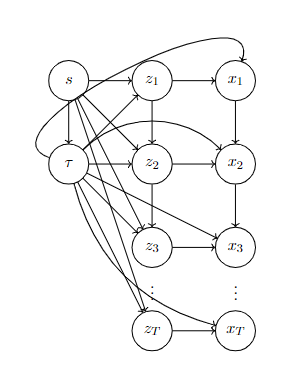
___

## Question 2 [Code] (10pts)

Implement the forward pass for a given scenario $s$ and hour-of-sinking $\tau$.

The forward pass is defined by the following recursion. For $t=2,\dots, T$:

$$\alpha_t^{\tau,s}(k) = \sum_{j=1}^K \, P_{s, \tau}(Z_t=k \mid Z_{t-1}=j) \, P_\tau({\boldsymbol{x}}_{t-1} \mid Z_{t-1}=j) \, \alpha_{t-1}^{\tau,s}(k)$$

The base case of the recursion is $t=1$:
$$\alpha_1^{\tau,s}(k) = \sum_{j=1}^K \, P_{s, \tau}(Z_1=k \mid Z_{0}=j) \, P(Z_0 = j)$$

Do not use any nested for-loops. Your code should contain a single loop over $t$ and matrix-vector operations.

In [ ]:
def forward_pass(tau, transition_matrix_KK, initial_dist_K, likelihood_TK):
    """ Compute the forward pass of the HMM for a given tau and scenario.
    
    Parameters
    ----------
    tau : int
        The time-of-sinking for the USS Scorpion.
    transition_matrix_KK : np.ndarray
        A (KxK) row-stochastic matrix for a given scenario.
    initial_dist_K : np.ndarray
        A (K,) vector representing the initial distribution over cells.
    likelihood_TK : np.ndarray
        A (TxK) matrix of likelihood values for the sonar data, for a given tau.

    Returns
    -------
    alpha_TK : np.ndarray
        A (TxK) matrix of forward pass values.
    """

    # Your code here
    alpha_TK = 
    T = likelihood_TK.shape[0]
    for (t in range(T)):
      alpha_TK

    return alpha_TK

## Question 3 [Math, code] (5pts)

Provide a way to compute the following quantity using the forward pass $\alpha_t^{\tau,s}(k)$ values.

$$ 
P(Z_T = k \mid s, \tau, \boldsymbol{x}_{1:T}) = ?
$$

___

Your answer here:

___

Then use your implementation of the forward pass to compute and visualize $P(Z_T = k \mid s, \tau, \boldsymbol{x}_{1:T})$ for the four combinations of $(s,\tau)$ given. (Your code should use `forward_pass` to compute `P_Z`.)

In [ ]:
for s in ['seek_ridge', 'flounder']:
    for tau in [5, 24]:
        
        # Your code here
        # ...
        # P_Z = ...

        assert P_Z.shape == (858,) and np.allclose(P_Z.sum(), 1)
        plot_dist_on_scorpion_search_grid(P_Z.reshape((33, 26)), show=True)

## Question 4 [Code] (10pts)

The backward pass is defined by the following recursion for $t=T-1,\dots, 0$:

$$
\beta^{\tau, s}_t(k) = \sum_{j=1}^K P_{s,\tau}(Z_{t+1}=j \mid Z_{t}=k)\, P_\tau({\boldsymbol{x}}_{t+1} \mid Z_{t+1}=j) \, \beta^{\tau, s}_{t+1}(k)
$$

where the base case of the recursion is for $t=T$:
$$\beta^{\tau, s}_T(k) = 1$$

Implement the backward pass. Again, do not use nested for-loops.

In [ ]:
def backward_pass(tau, transition_matrix_KK, likelihood_TK):
    """ Compute the forward pass of the HMM for a given tau and scenario.
    
    Parameters
    ----------
    tau : int
        The time-of-sinking for the USS Scorpion.
    transition_matrix_KK : np.ndarray
        A (KxK) row-stochastic matrix for a given scenario.
    likelihood_TK : np.ndarray
        A (TxK) matrix of likelihood values for the sonar data, for a given tau.

    Returns
    -------
    beta_TK : np.ndarray
        A (TxK) matrix of backward pass values.
    """
    # Your code here

    return beta_TK

## Question 5 [Math, code] (5pts)

Provide a way to compute the following quantity using the forward ($\alpha$) and backward ($\beta$) values.

$$ 
P(Z_t = k \mid s, \tau, \boldsymbol{x}_{1:T}) = ?
$$

___


Your answer here:

___

Then use your implementation of the forward and backward pass to compute and visualize the distribution $P(Z_t = k \mid s, \tau, \boldsymbol{x}_{1:T})$ for hour $t=15$ and the four combinations of $(s,\tau)$ given. (Your code should use `forward_pass` to compute `P_Z`.)

In [ ]:
t = 15
for s in ['reverse_course', 'flounder']:
    transition_matrix_KK = transition_matrices[s]
    for tau in [5, 24]:
        likelihood_TK = sonar_likelihood(sonar_data, tau)
        alpha_TK = forward_pass(tau, transition_matrix_KK, initial_dist_K, likelihood_TK)
        beta_TK = backward_pass(tau, transition_matrix_KK, likelihood_TK)
        
        # Your code here
        # ...
        # P_Z = ...
        
        assert P_Z.shape == (858,) and np.allclose(P_Z.sum(), 1)
        plot_dist_on_scorpion_search_grid(P_Z.reshape((33, 26)).copy(), show=True)

## Question 6 [Math] (20pts) 

All of the previous calculations conditioned on a specific scenario $s$ and hour-of-sinking $\tau$.

Derive an algorithm to exactly compute the following probability distribution:

$$P(Z_T = k \mid \boldsymbol{x}_{1:T})$$

Your algorithm **must involve the forwards and backwards passes** as a subroutine.

Please detail your algorithm in the space below. Use your discretion in how to communicate the details of your algorithm clearly. Provide enough detail for someone to implement it exactly, and enough detail to show how you derived it.

___

Your answer here:

___

## Question 7 [Code] (15pts) 

Implement your answer to Question 6.

Your code should call `forward_pass` and `backward_pass` and ultimately produce `posterior_Z`, which is the posterior in Question 6.

In [ ]:
# Your code here
# ..
# posterior_Z = ...

assert posterior_Z.shape == (858,) and np.allclose(posterior_Z.sum(), 1)
plot_dist_on_scorpion_search_grid(posterior_Z.reshape((33, 26)), show=True)

Run the following visualization code so that we see the exact probababilities of the posterior versus prior.

This will do the same thing as above, but using `seaborn.heatmap` with a colorbar.

In [ ]:
import seaborn as sns
_ = sns.heatmap(np.rot90(initial_dist_K.reshape((33, 26))))
_ = plt.title('Prior probability of $Z_0$')
plt.show()

_ = sns.heatmap(np.rot90(posterior_Z.reshape((33, 26))))
_ = plt.title('Posterior probability of $Z_T$')


## Question 8 [Code] (10pts) 

Write code to compute the following probability

$$P(S = s \mid \boldsymbol{x}_{1:T})$$

Your existing code should already be able to compute this. Re-use your existing code with as few modifications as possible.

In the space below, compute `posterior_S`, and then run the visualization code. 

(Make sure the indices of `posterior_S` are properly aligned with `prior_S`.)

In [ ]:
scenarios = df_scenarios['scenario'].values
prior_S = df_scenarios['p(s)'].values  # align indices of posterior_S to this

# Your code here
# ...
# posterior_S = ...
assert posterior_S.size == 6 and np.allclose(posterior_S.sum(), 1)

Run the following code to plot the prior versus posterior over scenarios.

In [ ]:
_ = plt.stem(scenarios, prior_S, use_line_collection=True)
_ = plt.xticks(rotation=75)
plt.title('Prior probability of each scenario')
plt.show()

_ = plt.stem(scenarios, posterior_S, use_line_collection=True)
_ = plt.xticks(rotation=75)
plt.title('Posterior probability of each scenario')
plt.show()